In [2370]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np

In [2371]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)

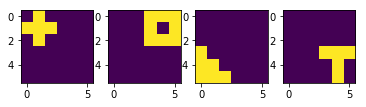

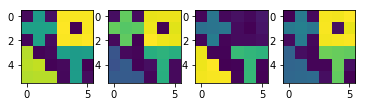

In [4625]:
# Synthetic Data Genration

'''Basis Generation'''
k1 = np.zeros((6,6))
k1[0:3,1] = 1.0
k1[1,0:3] = 1.0

k2 = np.zeros((6,6))
k2[0:3,-3:] = 1.0
k2[1,-2] = 0

k3 = np.zeros((6,6))
k3[-3:,0:3] = 1.0
k3[-3:-1,2] = 0.0
k3[-3,1:2] = 0.0

k4 = np.zeros((6,6))
k4[-3:,-2] = 1.0
k4[-3,-3:] = 1.0

fig, ax = plt.subplots(1,4)

ax[0].imshow(k1)
ax[1].imshow(k2)
ax[2].imshow(k3)
ax[3].imshow(k4)


'''Data Generation'''

train_size = 3000
test_size = 500

train_weights = np.random.rand(train_size, 4)
train_data = np.dot(train_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
train_data += np.random.normal(0,0.01, size = train_data.shape)

test_weights = np.random.rand(test_size, 4)
test_data = np.dot(test_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
test_data += np.random.normal(0,0.01, size = test_data.shape)


fig, ax = plt.subplots(1,4)

ax[0].imshow(train_data[0].reshape(6,6))
ax[1].imshow(train_data[300].reshape(6,6))
ax[2].imshow(test_data[0].reshape(6,6))
ax[3].imshow(test_data[300].reshape(6,6))

In [4626]:
BATCH_SIZE = 100

trainloader = torch.utils.data.DataLoader(train_data.reshape(-1,1,6,6), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


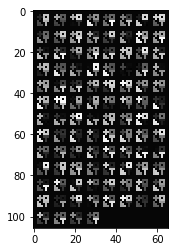

In [4627]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images = dataiter.next()
show_images(images)

In [4751]:
class GLM_NP(nn.Module):
    def __init__(self, latent_variable_dim, alpha = 1.0, rholr = 10e-12):
        super(GLM_NP, self).__init__()
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        
        # V : Stick breaking : Beta {kumaraswamy}
        self.aeys = nn.Parameter(torch.rand(1,latent_variable_dim) + 2)
        self.bees = nn.Parameter(torch.rand(1,latent_variable_dim) + 2)
        self.unif_sampler = torch.distributions.uniform.Uniform(self.eps1, 1-self.eps1)
        
        # IBP prior
        self.alpha = alpha
        self.euler_constant = np.e
        
        # Z : Bernoulli
        self.phi = nn.Parameter(torch.randn((36 + 1),latent_variable_dim))
        
        # Gumbel Softmax params
        self.temperature = 10
        self.t_prior = 0.1 # prior lambda
        
        self.gumbel_sampler = torch.distributions.gumbel.Gumbel(0,1)
        
        # Basis
        self.A = nn.Parameter(torch.randn(latent_variable_dim, 36))
        
        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
        ## Optimizer
        self.optimizer = None
        self.K = latent_variable_dim
        self.max_K = latent_variable_dim
        
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z, p):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        sample_size = 1000
        
        U = self.unif_sampler.sample([N,K,sample_size])
        G1 = self.unif_sampler.sample([N,K,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
        
        V = (1-U.pow(1/self.aeys[:,:K].view(-1,K,1))).pow(1/self.bees[:,:K].view(-1,K,1))
        
        pi = torch.zeros_like(V)+1
        for i in range(K):
            for j in range(i+1):
                pi[:,i,:] *= V[:,j,:]
        
        rand_num = torch.rand_like(pi)
        rand_logit = (rand_num/(1-rand_num)).log()
        
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        alpha = (logit_pi + inter_z.view(N,K,1)).sigmoid()
        logit_alpha = (alpha + self.eps1)/(1-alpha + self.eps1)
        
        z1 = (logit_alpha.log() + logit_G1)/self.temperature
        
        y = z1.sigmoid()
        
        
        return y, alpha, pi
        
    def forward(self, input, k):
        x = input.view(-1, 36)
        N, D = x.shape
        
        if(k == 0):
            k = self.get_current_K()
            
        
        inter_z = self.phi # 785 x K
        x_cat = torch.cat((input.view(N,36), torch.ones(N).view(N,-1)), 1).view(N,36+1) # N x 785
        inter_z = torch.mm(x_cat, inter_z[:,:k]) # N x K
        
        z, gi, pi = self.reparameterize_gumbel_kumaraswamy(inter_z, k) # N x K
        
        x = self.decode(z.mean(dim=-1).view(N,k), k)
        
        return x, z, gi, pi

    
    def decode(self, z, k):
        
        x = F.linear(z, self.A.transpose(0,1)[:,:k]).sigmoid()
        
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(1,k) + 2), 1))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(1,k) + 2), 1))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((36 + 1),k)), 1))
            self.A = nn.Parameter(torch.cat((self.A, torch.randn(k, 36)), 0))
            
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.get_current_K()):
            return
        with torch.no_grad():
            c_K = self.get_current_K()
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 1))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 1))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            self.A = nn.Parameter(list(torch.split(self.A, c_K - k , 0))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.K
    
    def constraint_proj(self):
        with torch.no_grad():
            self.aeys[self.aeys < 0.001] = 0.001
            self.bees[self.bees < 0.001] = 0.001
            self.rhos[self.rhos < 10e-6] = 10e-6
            self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6

In [4824]:
def get_kth_trunc_loss(model, images, K = 0):
    
    N = images.shape[0]
    
    recon_image, z, gi, pi = model(images, K)
    softplus = nn.Softplus()
    eps = model.eps1
    if(K == 0):
        K = model.aeys.shape[1]
    
    z = z[:,:K]
    pi = pi[:,:K]
    gi = gi[:,:K]
    
    
    KL_kuma = ((model.aeys - model.alpha)/(model.aeys))*(-model.euler_constant -torch.digamma(model.bees) - 1/model.bees)
    KL_kuma += (model.aeys.log() + model.bees.log())
    KL_kuma -= (model.bees - 1)/(model.bees)
    
#     print(KL_kuma)
    KL_kuma = torch.sum(KL_kuma[:,:K])/N
    
    logit_pi = (pi+eps).log() - (1-pi+eps).log()
    logit_x  =  (z+eps).log() - (1 -z+eps).log()
    logit_gi = (gi+eps).log() - (1-gi+eps).log()
    
    

    tau = model.temperature
    tau_prior = model.t_prior
    
    exp_term_p = logit_pi - logit_x*(tau_prior)
    exp_term_q = logit_gi - logit_x*(tau)
    
    log_tau = torch.log(torch.tensor(model.temperature, requires_grad = False))
    
    
    
    log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
    log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)
    
    
    mask_K = torch.zeros_like(log_pz)
    mask_K[:,:K] = 1
    
    
#     log_pz = (mask_K*log_pz)[log_pz == log_pz]
#     log_qz = (mask_K*log_qz)[log_qz == log_qz]

    
    KL_gumb = (log_qz - log_pz)
    
    KL_gumb[KL_gumb != KL_gumb] = 0
#     KL_gumb[KL_gumb < 0] = 0
#     print(KL_gumb.shape)
    KL_gumb = torch.sum(KL_gumb.mean(dim =-1))#.abs()
    KL_gumb /= N
    
    
    ''' Add some more KL terms from K||B ,  '''
    
    Lik = -0.5*(recon_image - images.view(-1,36)).pow(2)
    
    Lik = torch.sum(Lik)/N - float(36*0.5*np.log(2*np.pi))
    
    KL_l = KL_kuma + KL_gumb
    
    print(Lik, KL_kuma, KL_gumb)
    
    return -Lik  + KL_l

In [4825]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.get_current_K()
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    model.K = new_K
    optimizer = torch.optim.Adam(model.parameters(), 0.1)
    
    return optimizer

In [4826]:
def rrs_loss(model, images, curr_K):
    
    l = torch.zeros(curr_K+1,1)
    for i in range(1,curr_K+1):
        l[i,:] = get_kth_trunc_loss(model, images, K = i)
        
    
    one_minus_rho = (1 - model.rhos[0:curr_K+1]).view(curr_K+1,1)
    
    return l, one_minus_rho

In [4827]:
def train_step(model, images, add_max = 5, sample = False, keep_graph = False):
    
    """ sample a trucation level and then do the same"""
    
    curr_K = model.get_current_K()
    model.rhos[0] = 1.0
    model.optimizer = retain_k_nodes(model , new_K = model.max_K+1)
    model.optimizer = retain_k_nodes(model , new_K = model.max_K)
    
    
    if(sample):
        
#         model.rhos[-1] = 0.5
        curr_K = model.get_current_K()
        # Sample a truncation level
        m_k = torch.zeros(curr_K,1)
        
        for i in range(curr_K):
            prod = 1
            for j in range(i+1):
                prod*=model.rhos[j,:]

            m_k[i,:] = (1-model.rhos[i+1])#*prod
            
        m_k /= m_k.sum()
        print(m_k)
#         assert(1==2)

        new_values = np.random.choice(np.arange(curr_K)+1,size = 1, p = m_k.view(1,-1).detach().numpy()[0])
        new_value = int(np.max(new_values))+1


        if(new_value > model.max_K):
            model.optimizer = retain_k_nodes(model , new_K = new_value)
            model.K = new_value
            model.max_K = new_value
        else:
            model.optimizer = retain_k_nodes(model , new_K = model.max_K)
            model.K = new_value
        
        
    else:
        new_value = curr_K
    
    

    print("Current Truncated Level :", new_value)
    print(model.rhos)
    model.optimizer.zero_grad()
    curr_K = model.get_current_K()
    
    
    l ,one_minus_rho = rrs_loss(model, images, curr_K)
    l[l != l] = 0
    l_final_params = (l*one_minus_rho).sum()
#     print(l,one_minus_rho,l_final_params)
    
    
    ws = torch.zeros(curr_K+1, curr_K+1)
    
    for k in range(1,curr_K+1):
        for i in range(k-1,curr_K+1):
            if(i < k-1):
                ws[k,i] = 0
            elif(i == k-1):
                ws[k,i] = 1/(model.rhos[k] - 1)
            else:
                ws[k,i] = 1/model.rhos[k]
            
    
    rho_grads = (ws*(-l)*one_minus_rho).sum(dim = 0)/len(images)
    rho_grads[rho_grads != rho_grads] = 0.0
    
    model.rhos[:curr_K+1,:] = model.rhos[:curr_K+1,:] + model.rholr*(rho_grads.view(-1,1))
    

    
    if(l_final_params != l_final_params):
        pass
    else:
        l_final_params.backward()
        model.optimizer.step()
        
    model.constraint_proj()
    
    return l_final_params

In [4832]:
glm = GLM_NP(1,4,10e-2)
glm.optimizer = retain_k_nodes(glm , new_K = 2)

In [4833]:
## train
train_loss = []
glm.temperature = 10.0
keep_graph = True

Epoch no : 50 batch_no : 29 curr_loss : -0.009952122569084168


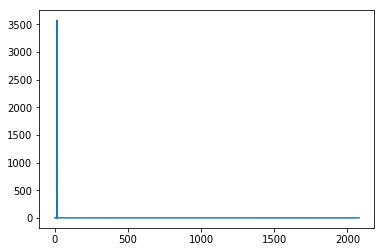

In [4849]:
# optimizer = torch.optim.Adam(glm.parameters(), 0.05)
for epoch in range(50):
    
        
    for i, data in enumerate(trainloader, 0):
        images = data.float()
        images = images.to(device)
            
        if((30*epoch + i)%1 == 0 and True):
            l = train_step(glm, images, 1, True, keep_graph)
        else:
            l = train_step(glm, images, 1, False, keep_graph)
            
        
        
        train_loss.append((l/((1 - glm.rhos[:-1]).sum())).item() / len(images))

        glm.temperature /= 1.1
        if(glm.temperature < .01):
            glm.temperature = 0.01
        

#         optimizer.zero_grad()
#         l = get_kth_trunc_loss(glm, images, K = 0)
#         try:
#             l.backward()
#         except:
#             pass
#         train_loss.append(l.item() / len(images))
#         optimizer.step()
    
        

        if(i%1 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1])
        
plt.plot(train_loss)
plt.show()

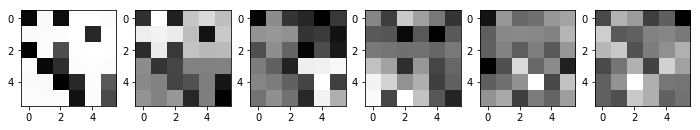

In [4854]:
K = 6#max(glm.get_current_K(),2)
fig, ax = plt.subplots(1,K, figsize = [2*K,6])
for i in range(K):
    ax[i].imshow(glm.A[i].view(6,6).detach(), cmap= 'gray')
plt.show()

In [4855]:
glm.temperature

0.01

In [4856]:
glm.aeys

Parameter containing:
tensor([[100.9620, 148.6186,  26.2357,  28.1759,  27.0047,  18.8933,   3.9172,
           2.2369,   2.9516,   3.0903]], requires_grad=True)

In [4857]:
glm.bees

Parameter containing:
tensor([[ 18.4877,   5.3557,  46.3793, 100.3862,  92.5129,  37.0796,   9.3507,
           3.3269,   2.7849,   2.8354]], requires_grad=True)

In [4858]:
glm.rhos

tensor([[9.9999e-01],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [9.9999e-01],
        [9.9999e-01],
        [9.9999e-01],
        [9.9999e-01],
        [9.9999e-01]], grad_fn=<CopySlices>)

In [4859]:
train_data.max()

1.0261059813129105

In [4860]:
glm.max_K

10

In [4861]:
glm.K

7